In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

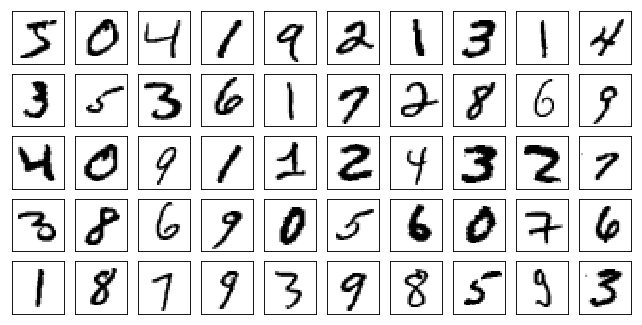

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
                
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*2*2, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*2*2)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [15]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.304041 drop: 2.327013 plain: 2.341997
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 2.020928 drop: 2.054725 plain: 2.016561
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.845913 drop: 1.615289 plain: 1.601929
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.655893 drop: 1.231732 plain: 1.226650
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 1.616491 drop: 1.136762 plain: 1.081200
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 1.405914 drop: 0.768216 plain: 0.775876
Test set:
bn: Loss: 1.4753	Accuracy: 8651.0/10000 (87%)
drop: Loss: 0.9521	Accuracy: 8407.0/10000 (84%)
plain: Loss: 0.9310	Accuracy: 8482.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 1.546558 drop: 1.127594 plain: 1.066347
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 1.398991 drop: 0.827654 plain: 0.829067
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 1.250664 drop: 0.698119 plain: 0.687887
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 1.244712 drop: 0.756642 plain: 0.72

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.029960 drop: 0.035029 plain: 0.036261
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.136868 drop: 0.186493 plain: 0.201434
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.032368 drop: 0.072137 plain: 0.069511
Test set:
bn: Loss: 0.0707	Accuracy: 9822.0/10000 (98%)
drop: Loss: 0.0984	Accuracy: 9726.0/10000 (97%)
plain: Loss: 0.0961	Accuracy: 9750.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.048344 drop: 0.118136 plain: 0.134746
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.047702 drop: 0.068435 plain: 0.078907
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.229070 drop: 0.247208 plain: 0.182269
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.024023 drop: 0.076383 plain: 0.061083
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.029347 drop: 0.044056 plain: 0.049483
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.072836 drop: 0.104097 plain: 0.118123
Test set:
bn: Loss: 0.0660	Accuracy: 9830.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.024804 drop: 0.037300 plain: 0.049617
Test set:
bn: Loss: 0.0463	Accuracy: 9869.0/10000 (99%)
drop: Loss: 0.0650	Accuracy: 9801.0/10000 (98%)
plain: Loss: 0.0592	Accuracy: 9835.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.063679 drop: 0.075288 plain: 0.080048
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.012234 drop: 0.015564 plain: 0.013078
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.145785 drop: 0.120428 plain: 0.125799
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.044574 drop: 0.087654 plain: 0.112284
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.040417 drop: 0.022998 plain: 0.015977
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.050015 drop: 0.066212 plain: 0.068569
Test set:
bn: Loss: 0.0435	Accuracy: 9873.0/10000 (99%)
drop: Loss: 0.0635	Accuracy: 9800.0/10000 (98%)
plain: Loss: 0.0575	Accuracy: 9837.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.020720 drop: 0.036909 plain: 0.028999
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.023725 drop: 0.073818 plain: 0.100012
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.005746 drop: 0.020491 plain: 0.014996
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.006497 drop: 0.024873 plain: 0.015879
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.010626 drop: 0.028565 plain: 0.033568
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.007892 drop: 0.032253 plain: 0.016844
Test set:
bn: Loss: 0.0417	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0525	Accuracy: 9834.0/10000 (98%)
plain: Loss: 0.0466	Accuracy: 9863.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.029568 drop: 0.033046 plain: 0.028468
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.014398 drop: 0.031961 plain: 0.029940
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.001512 drop: 0.005827 plain: 0.005056
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.022529 drop: 0.035084 plain: 0.029209
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.004720 drop: 0.046

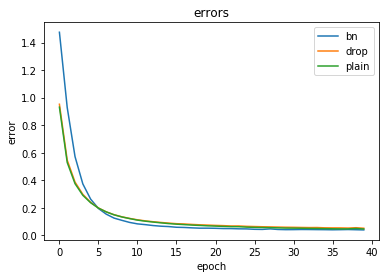

In [17]:
plot_graphs(test_log, 'loss')

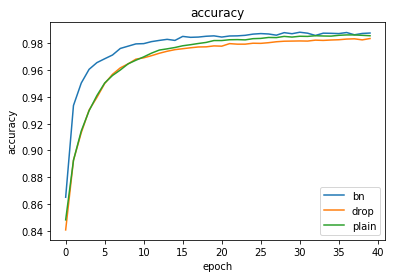

In [18]:
plot_graphs(test_log, 'accuracy')

In [19]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [10]:
model = torch.load('./model_classifier_convs')

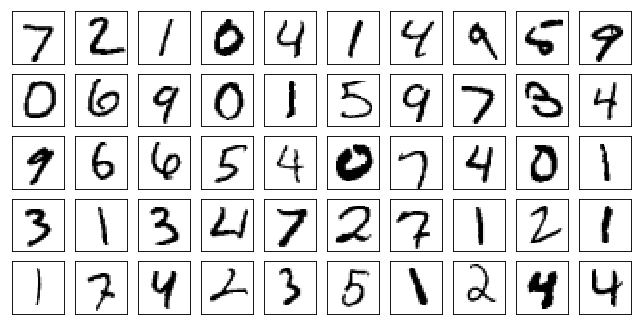

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(6), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [11]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

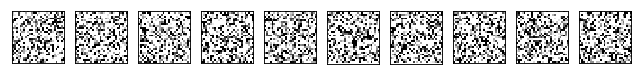

In [28]:
data, _ = next(iter(test_loader))
img = torch.randn((10, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 10))


In [37]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(torch.long)
    lr = 1e-2    
    loss_stats = [] 
            
    for i in range(1, 5000001):  
             
        out = model.forward(F.sigmoid(gen_img_par))        
             
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)    
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 20000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - stop
                if not down:
                    print ("Stop ..")
                    break
                

        if i % 200000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 10))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 10000: loss=0.11845637857913971
Iteration 20000: loss=0.11739128828048706
Iteration 30000: loss=0.11629930883646011
Iteration 40000: loss=0.11531748622655869
Iteration 50000: loss=0.11375927925109863
Iteration 60000: loss=0.11274222284555435
Iteration 70000: loss=0.11210459470748901
Iteration 80000: loss=0.10997267812490463
Iteration 90000: loss=0.10860289633274078
Iteration 100000: loss=0.10828207433223724


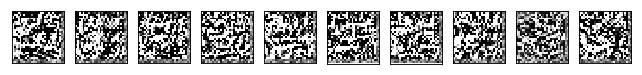

Iteration 110000: loss=0.10822682082653046
Iteration 120000: loss=0.10806753486394882
Iteration 130000: loss=0.10816065222024918
Iteration 140000: loss=0.10756498575210571
Iteration 150000: loss=0.10761602222919464
Iteration 160000: loss=0.1074557676911354
Iteration 170000: loss=0.107127845287323
Iteration 180000: loss=0.10697503387928009
Iteration 190000: loss=0.10573313385248184
Iteration 200000: loss=0.10554225742816925


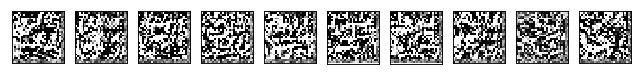

Iteration 210000: loss=0.10519915819168091
Iteration 220000: loss=0.1052093505859375
Iteration 230000: loss=0.10464316606521606
Iteration 240000: loss=0.10433469712734222
Iteration 250000: loss=0.10414210706949234
Iteration 260000: loss=0.10404063761234283
Iteration 270000: loss=0.10404320061206818
Iteration 280000: loss=0.10412496328353882
Iteration 290000: loss=0.10408897697925568
Iteration 300000: loss=0.10295262187719345


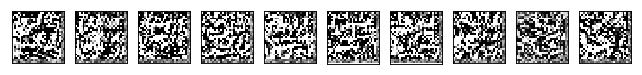

Iteration 310000: loss=0.10285995900630951
Iteration 320000: loss=0.10295845568180084
Iteration 330000: loss=0.10267223417758942
Iteration 340000: loss=0.10270684957504272
Iteration 350000: loss=0.10268665850162506
Iteration 360000: loss=0.10265175998210907
Iteration 370000: loss=0.10282380878925323
Iteration 380000: loss=0.10272850841283798
Iteration 390000: loss=0.1021021232008934
Iteration 400000: loss=0.10210802406072617


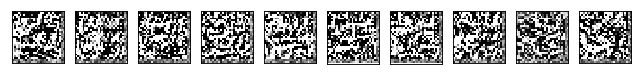

Iteration 410000: loss=0.1020512580871582
Iteration 420000: loss=0.10191573947668076
Iteration 430000: loss=0.10200518369674683
Iteration 440000: loss=0.10201642662286758
Iteration 450000: loss=0.10191424190998077
Iteration 460000: loss=0.10182805359363556
Iteration 470000: loss=0.1017974242568016
Iteration 480000: loss=0.10175205767154694
Iteration 490000: loss=0.10175037384033203
Iteration 500000: loss=0.1016036719083786


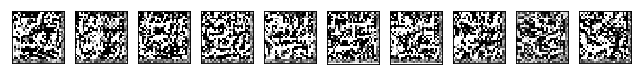

Iteration 510000: loss=0.10160668194293976
Iteration 520000: loss=0.10163621604442596
Iteration 530000: loss=0.10148898512125015
Iteration 540000: loss=0.10152348130941391
Iteration 550000: loss=0.10105518996715546
Iteration 560000: loss=0.10086120665073395
Iteration 570000: loss=0.10084746778011322
Iteration 580000: loss=0.10082890093326569
Iteration 590000: loss=0.10076679289340973
Iteration 600000: loss=0.10069891065359116


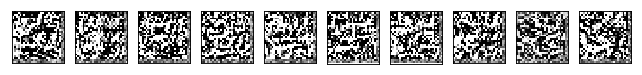

Iteration 610000: loss=0.10063646733760834
Iteration 620000: loss=0.10066553205251694
Iteration 630000: loss=0.10041210800409317
Iteration 640000: loss=0.10037185251712799
Iteration 650000: loss=0.10025517642498016
Iteration 660000: loss=0.10026748478412628
Iteration 670000: loss=0.10021009296178818
Iteration 680000: loss=0.10015518963336945
Iteration 690000: loss=0.09978796541690826
Iteration 700000: loss=0.0994931012392044


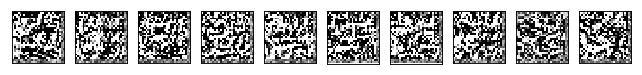

Iteration 710000: loss=0.0994320958852768
Iteration 720000: loss=0.0992901474237442
Iteration 730000: loss=0.09594829380512238
Iteration 740000: loss=0.09554845839738846
Iteration 750000: loss=0.09546241909265518
Iteration 760000: loss=0.09542135894298553
Iteration 770000: loss=0.09538491070270538
Iteration 780000: loss=0.09536930173635483
Iteration 790000: loss=0.09537043422460556
Iteration 800000: loss=0.09531558305025101


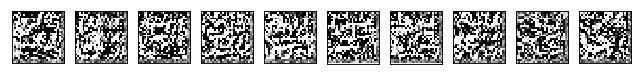

Iteration 810000: loss=0.0953439325094223
Iteration 820000: loss=0.0952250212430954
Iteration 830000: loss=0.09519799798727036
Iteration 840000: loss=0.0952400490641594
Iteration 850000: loss=0.09529288113117218
Iteration 860000: loss=0.09522080421447754
Iteration 870000: loss=0.09506159275770187
Iteration 880000: loss=0.09501947462558746
Iteration 890000: loss=0.09503696113824844
Iteration 900000: loss=0.0949743315577507


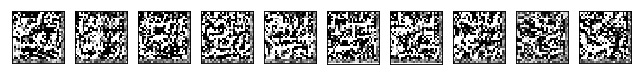

Iteration 910000: loss=0.09487758576869965
Iteration 920000: loss=0.09474362432956696
Iteration 930000: loss=0.0946381613612175
Iteration 940000: loss=0.09452511370182037
Iteration 950000: loss=0.09457036107778549
Iteration 960000: loss=0.09458479285240173
Iteration 970000: loss=0.09434964507818222
Iteration 980000: loss=0.09428970515727997
Iteration 990000: loss=0.09417574852705002
Iteration 1000000: loss=0.09418068826198578


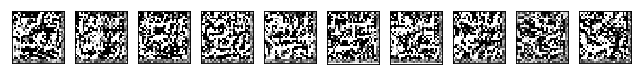

In [38]:
new_image_randn, loss_stats = generate_image(img)

Сгенерированное изображение цифры "2"

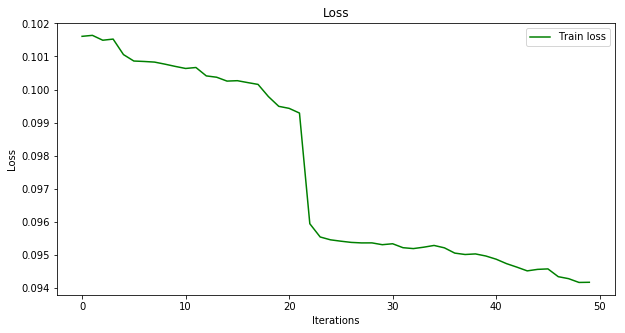

In [39]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Loss")
plt.plot(loss_stats[50:], color='green', label='Train loss')

ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.legend()
